<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/RAFT/RAFT_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RAFT Starter**

In this notebook we will learn how to use [RAFT](https://arxiv.org/pdf/2003.12039.pdf) or Recurrent All-Pairs Field Transforms for Optical Flow

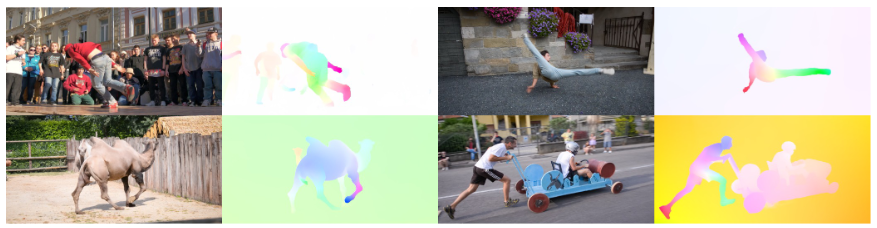

## **RAFT Models**

RAFT has several pretrained models:
 - raft-chairs - trained on FlyingChairs
 - raft-things - trained on FlyingChairs + FlyingThings
 - raft-sintel - trained on FlyingChairs + FlyingThings + Sintel + KITTI
 - raft-kitti - raft-sintel finetuned on only KITTI
 - raft-small - trained on FlyingChairs + FlyingThings

Clone the repo and import libraries

In [1]:
!git clone https://github.com/princeton-vl/RAFT.git

Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 147 (delta 0), reused 2 (delta 0), pack-reused 144
Receiving objects: 100% (147/147), 10.01 MiB | 29.22 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

Add RAFT core to path

In [3]:
sys.path.append('RAFT/core')

Get demo frames

In [ ]:
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_1.png
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_2.png
# !wget https://github.com/itberrios/CV_projects/blob/main/RAFT/test_images/fan_frame_3.png

In [ ]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_1.png
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_2.png
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_3.png

--2023-10-01 02:08:15--  https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126425 (123K) [image/png]
Saving to: ‘fan_frame_1.png’

fan_frame_1.png     100%[===================>] 123.46K  --.-KB/s    in 0.02s   

2023-10-01 02:08:15 (5.15 MB/s) - ‘fan_frame_1.png’ saved [126425/126425]

--2023-10-01 02:08:15--  https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [11]:
import subprocess

env = os.environ.copy()
frame_paths = []
for i in range(75):
    cmd = f"wget https://raw.githubusercontent.com/itberrios/CV_projects/main/RAFT/test_images/fan_frame_{i}.png"
    subprocess.run(cmd, shell=True, env=env)

    frame_paths.append(f"fan_frame_{i}.png")

In [13]:
frame_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [74]:
demo_path = 'RAFT/demo-frames'
frame1 = cv2.imread('fan_frame_1.png')
frame2 = cv2.imread('fan_frame_2.png')
frame3 = cv2.imread('fan_frame_3.png')

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

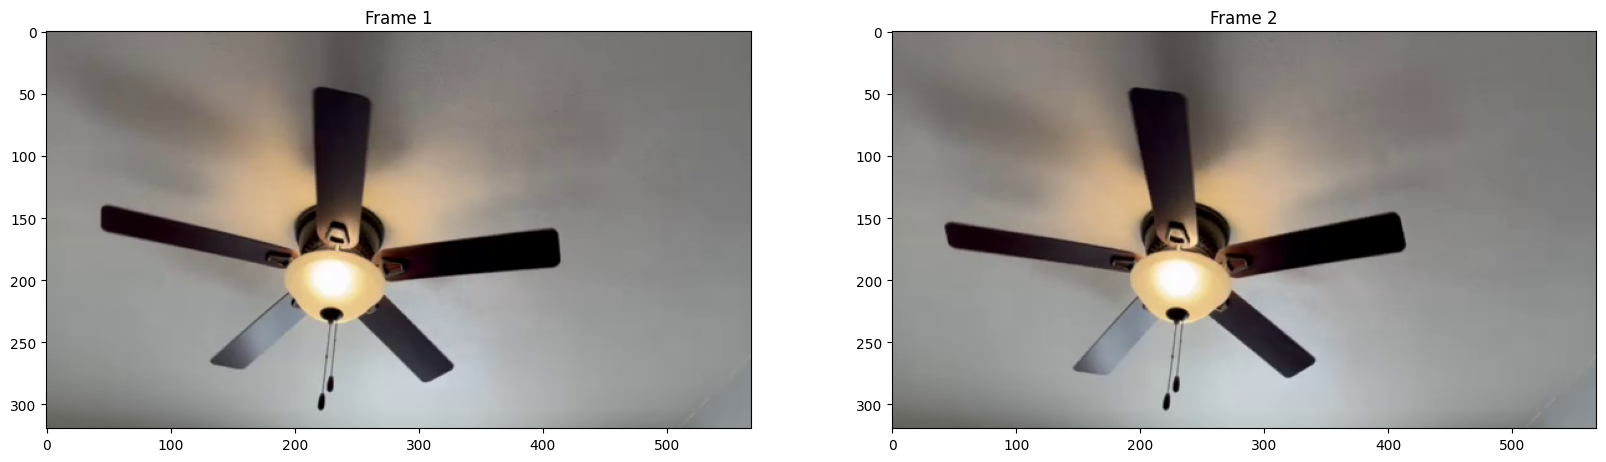

In [75]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(frame1)
ax[0].set_title("Frame 1")
ax[1].imshow(frame2)
ax[1].set_title("Frame 2");

## Download models

In [16]:
%cd RAFT
!./download_models.sh
# !python demo.py --model=models/raft-things.pth --path=demo-frames
%cd ..

/content/RAFT
--2023-10-01 12:48:12--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.80.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.80.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  18.3MB/s    in 5.8s    

2023-10-01 12:48:20 (13.5 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  inflating: models/raft-chairs.pth  
  inflating: models/raft-things.pth  
  inflating: models/raft-small.pth   
/content


### Helper functions

In [17]:
from collections import OrderedDict
from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder



def process_img(img, device):
    return torch.from_numpy(img).permute(2, 0, 1).float()[None].to(device)


def load_model(weights_path, args):
    model = RAFT(args)
    pretrained_weights = torch.load(weights_path, map_location=torch.device("cpu"))
    model = torch.nn.DataParallel(model)
    model.load_state_dict(pretrained_weights)
    model.to("cuda")
    return model


def inference(model, frame1, frame2, device, pad_mode='sintel',
              iters=12, flow_init=None, upsample=True, test_mode=True):

    model.eval()
    with torch.no_grad():
        # preprocess
        frame1 = process_img(frame1, device)
        frame2 = process_img(frame2, device)

        padder = InputPadder(frame1.shape, mode=pad_mode)
        frame1, frame2 = padder.pad(frame1, frame2)

        # predict flow
        if test_mode:
          flow_low, flow_up = model(frame1,
                                    frame2,
                                    iters=iters,
                                    flow_init=flow_init,
                                    upsample=upsample,
                                    test_mode=test_mode)



          return flow_low, flow_up

        else:
            flow_iters = model(frame1,
                               frame2,
                               iters=iters,
                               flow_init=flow_init,
                               upsample=upsample,
                               test_mode=test_mode)

            return flow_iters


def get_viz(flo):
    flo = flo[0].permute(1,2,0).cpu().numpy()
    return flow_viz.flow_to_image(flo)

# sketchy class to pass to RAFT
class Args():
  def __init__(self, model='', path='', small=False, mixed_precision=True, alternate_corr=False):
    self.model = model
    self.path = path
    self.small = small
    self.mixed_precision = mixed_precision
    self.alternate_corr = alternate_corr

  """ Sketchy hack to pretend to iterate through the class objects """
  def __iter__(self):
    return self

  def __next__(self):
    raise StopIteration

### Load Model

In [18]:
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

### Predict Optical Flow

In [19]:
flow_low, flow_up = inference(model, frame1, frame2, device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
flow_low.shape, flow_up.shape

(torch.Size([1, 2, 40, 71]), torch.Size([1, 2, 320, 568]))

### Display Results

In [21]:
flow_low_viz = get_viz(flow_low)
flow_up_viz = get_viz(flow_up)

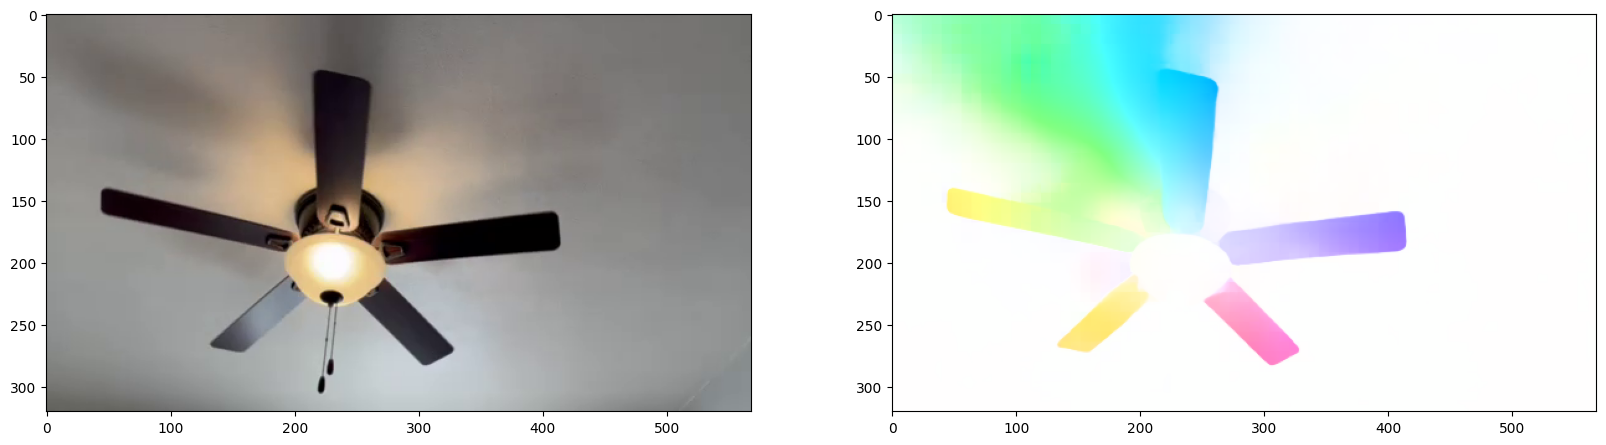

In [22]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(frame1)
ax1.imshow(flow_up_viz)
plt.show()

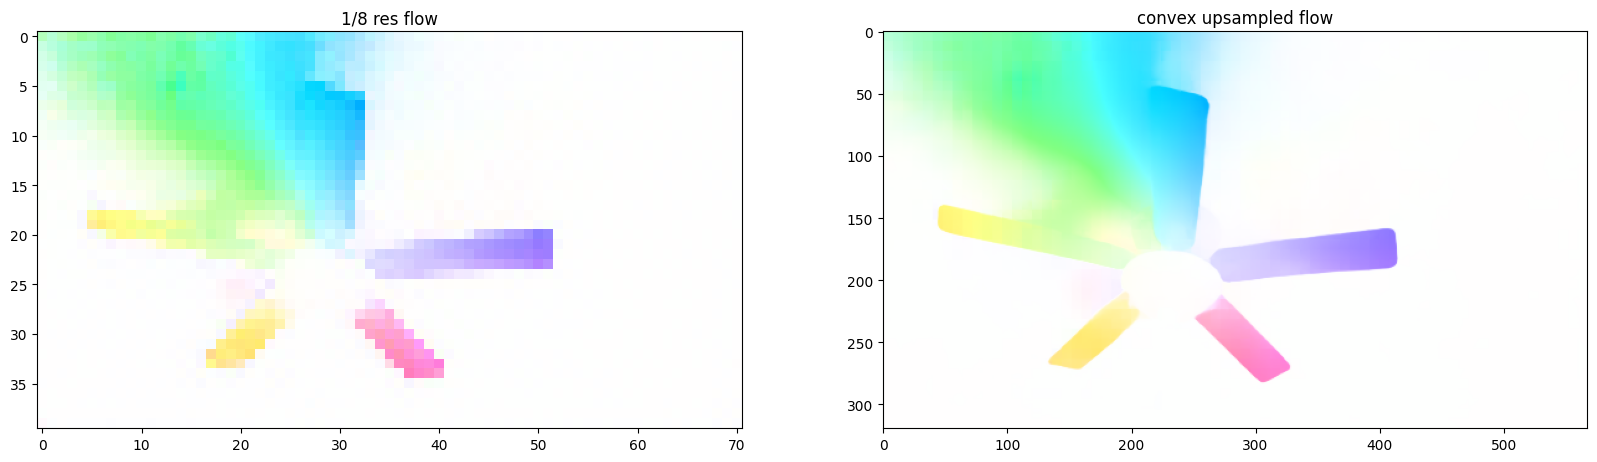

In [23]:
, itfrom matplotlib.colors import LogNorm

f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(flow_low_viz)
ax0.set_title('1/8 res flow')
ax1.imshow(flow_up_viz)
ax1.set_title('convex upsampled flow');

In [24]:
flow_iters = inference(model, frame1, frame2, device='cuda', iters=20, test_mode=False)

In [ ]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

Save flow iters

In [ ]:
for i in range(0, len(flow_iters)):
    # cv2.imwrite(f"flow_iter_{i}.png", get_viz(flow_iters[i]))
    fig = plt.figure(figsize=(20, 10))
    plt.imshow(get_viz(flow_iters[i]))
    plt.title(f"Iteration {i}")
    fig.savefig(f"flow_iter_{i}.png");

## **Estimate Flow with a Warm Start**

In [76]:
# get previous estimate at 1/8 res
flow_lo, flow_up = inference(model, frame1, frame2, device='cuda', pad_mode=None, iters=20, test_mode=True)

# 0 initialization
flow_lo_cold, flow_up_cold = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

# warm initialization
flow_lo_warm, flow_up_warm = inference(model, frame2, frame3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

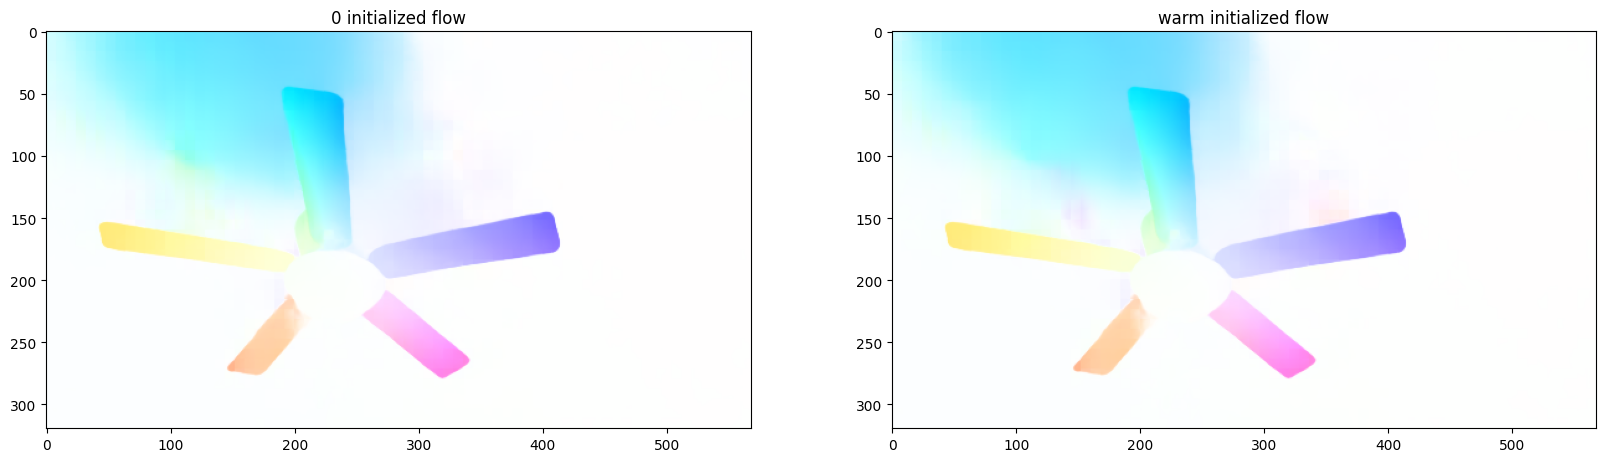

In [77]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_up_cold))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_up_warm))
ax1.set_title('warm initialized flow');

# **Make a GIF of the fan video**

In [294]:
from PIL import Image
from glob import glob


def create_gif_from_images(save_path, image_path, ext):
    ''' creates a GIF from a folder of images
        Inputs:
            save_path (str) - path to save GIF
            image_path (str) - path where images are located
            ext (str) - extension of the images
        Outputs:
            None

        Update:
            Add functionality for multiple extensions
    '''
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))

    pil_images = [Image.open(im_path ) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

Get warm-start flow estimates

In [40]:
# store results
cold_flow_frames = []
flow_frames = []

# warm start
prev_frame = cv2.cvtColor(cv2.imread(frame_paths[0]), cv2.COLOR_BGR2RGB)
frame = cv2.cvtColor(cv2.imread(frame_paths[1]), cv2.COLOR_BGR2RGB)
flow_lo, flow_up = inference(model, prev_frame, frame, device='cuda', iters=25, pad_mode=None, test_mode=True)

flow_frames.append(flow_up)
cold_flow_frames.append(flow_up)
prev_frame = frame.copy()

for i, fp in enumerate(frame_paths[2:]):
    frame = cv2.cvtColor(cv2.imread(fp), cv2.COLOR_BGR2RGB)

    cold_flow_lo, cold_flow_up = inference(model, prev_frame, frame, device='cuda', flow_init=None, iters=25, pad_mode=None, test_mode=True)
    flow_lo, flow_up = inference(model, prev_frame, frame, device='cuda', flow_init=flow_lo, iters=25, pad_mode=None, test_mode=True)

    flow_frames.append(flow_up)
    cold_flow_frames.append(cold_flow_up)
    prev_frame = frame.copy()

Code to filter image

In [295]:
def filter_image(frame):
    # grayscale
    filtered = cv2.GaussianBlur(frame, dst=None, ksize=(3,3), sigmaX=3)
    filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
    filtered = cv2.GaussianBlur(filtered, dst=None, ksize=(5,5), sigmaX=5)
    filtered[filtered < 10] = 0
    filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=10, beta=0)

    # repeated
    # filtered = cv2.GaussianBlur(frame, dst=None, ksize=(3,3), sigmaX=1)
    # filtered = cv2.Laplacian(filtered, dst=None, ddepth=-1, ksize=3, scale=10, delta=1)
    # filtered = cv2.convertScaleAbs(filtered, dst=None, alpha=1, beta=0)

    # TEMP
    # tmp = cv2.GaussianBlur(frame, dst=None, ksize=(3,3), sigmaX=3)
    # tmp = cv2.Laplacian(tmp, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
    # # tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=1, beta=0)
    # tmp = cv2.GaussianBlur(tmp, dst=None, ksize=(5,5), sigmaX=5)
    # # tmp = cv2.Laplacian(tmp, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
    # # tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=1, beta=0)
    # tmp[tmp < 10] = 0
    # tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=1, beta=0)

    # return tmp

    return filtered

In [316]:
# store results
cold_flow_frames = []
flow_frames = []

for i in range(2, len(frame_paths)):
    # # get frames
    # frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2RGB)
    # frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2RGB)
    # frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2RGB)

    # get frames
    frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
    frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
    frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

    # Filter
    frame_1 = filter_image(frame_1)
    frame_2 = filter_image(frame_2)
    frame_3 = filter_image(frame_3)

    # repeat last 3 dimensions
    frame_1 = np.repeat(frame_1[:, :, None], 3, axis=-1)
    frame_2 = np.repeat(frame_2[:, :, None], 3, axis=-1)
    frame_3 = np.repeat(frame_3[:, :, None], 3, axis=-1)

    # get previous estimate at 1/8 res
    flow_lo, flow_up = inference(model, frame_1, frame_2, device='cuda', pad_mode=None, iters=20, test_mode=True)

    # 0 initialization
    flow_lo_cold, flow_up_cold = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=None, iters=20, test_mode=True)

    # warm initialization
    flow_lo_warm, flow_up_warm = inference(model, frame_2, frame_3, device='cuda', pad_mode=None, flow_init=flow_lo, iters=20, test_mode=True)

    # save results
    flow_frames.append(flow_up_warm)
    cold_flow_frames.append(flow_up_cold)

Check results

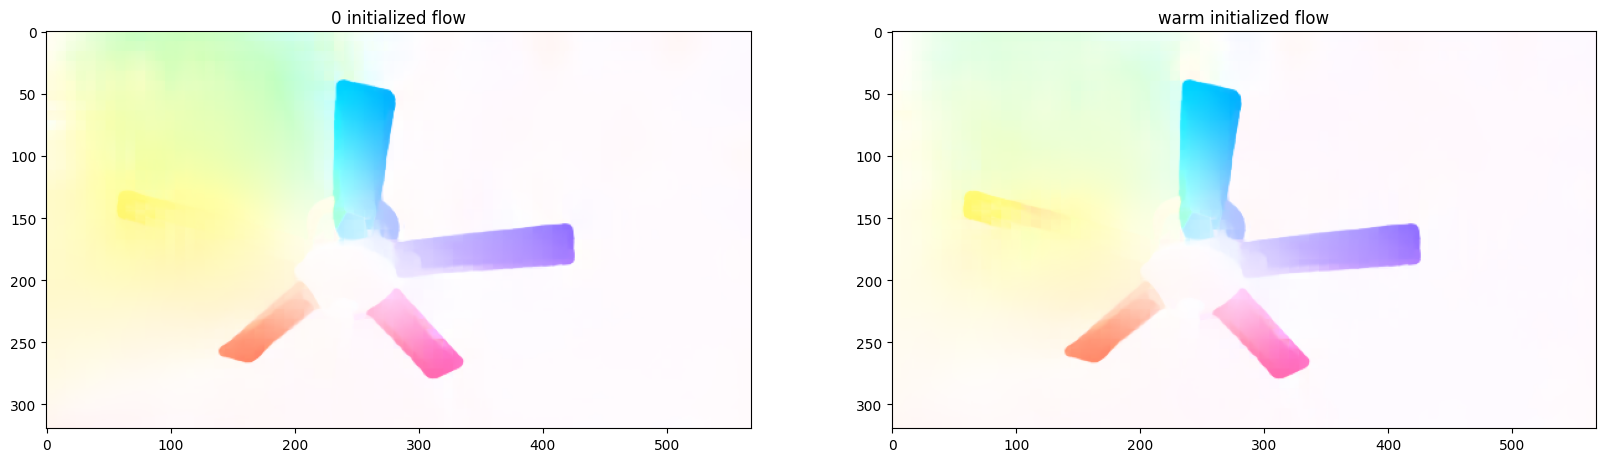

In [317]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(cold_flow_frames[-1]))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(flow_frames[-1]*50))
ax1.set_title('warm initialized flow');

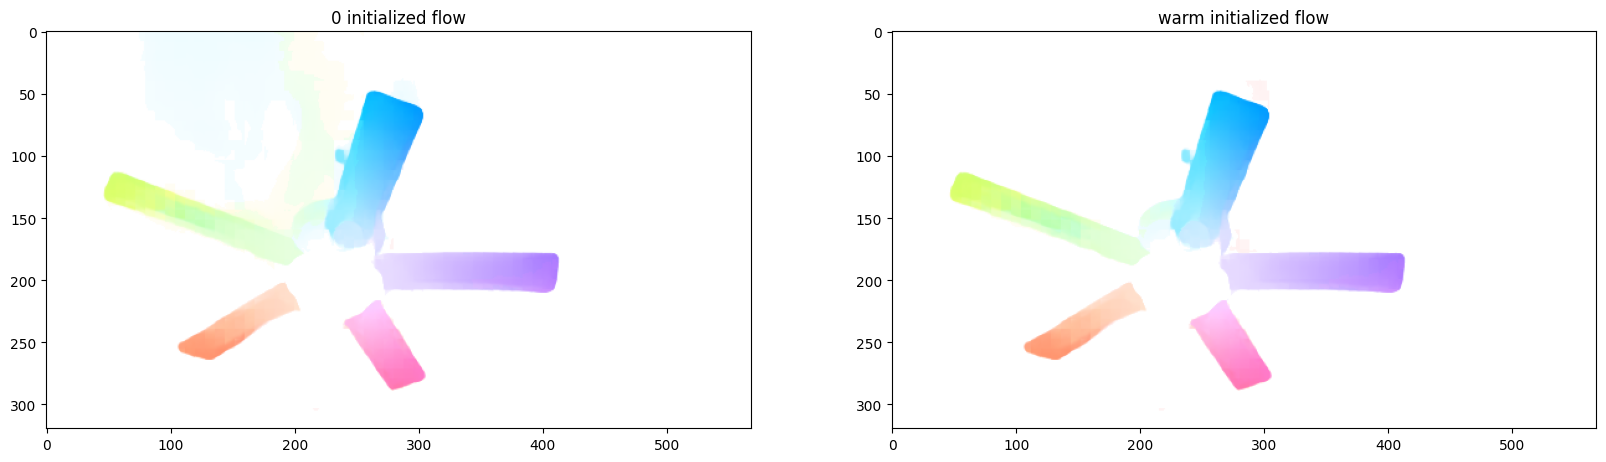

In [320]:
# filter results

idx = 10
cold = cold_flow_frames[idx].clone()
cold[torch.abs(cold) < 1] = 0

warm = flow_frames[idx].clone()
warm[torch.abs(warm) < 1] = 0

f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(cold))
ax0.set_title('0 initialized flow')
ax1.imshow(get_viz(warm))
ax1.set_title('warm initialized flow');

In [312]:
cold.min(), cold.max()

(tensor(-22.7667, device='cuda:0'), tensor(12.9424, device='cuda:0'))

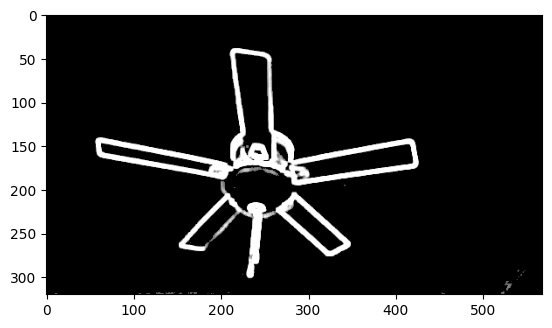

In [310]:
plt.imshow(frame_3)

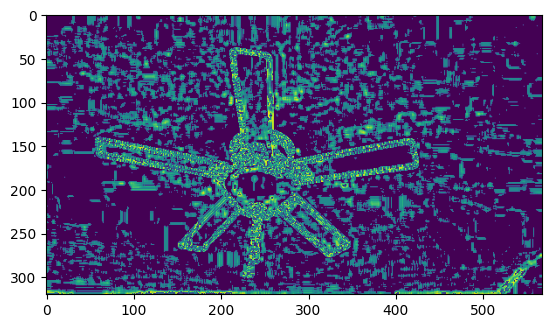

In [265]:
plt.imshow(filter_image(frame_3)*10)

In [286]:
frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

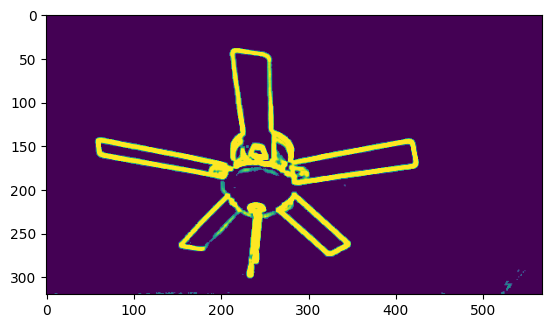

In [293]:
tmp = cv2.GaussianBlur(frame_3, dst=None, ksize=(3,3), sigmaX=3)
tmp = cv2.Laplacian(tmp, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
# tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=1, beta=0)

tmp = cv2.GaussianBlur(tmp, dst=None, ksize=(5,5), sigmaX=5)
# tmp = cv2.Laplacian(tmp, dst=None, ddepth=-1, ksize=1, scale=7, delta=1)
# tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=1, beta=0)
tmp[tmp < 10] = 0
tmp = cv2.convertScaleAbs(tmp, dst=None, alpha=10, beta=0)
# tmp[tmp < 10] = 0

plt.imshow(tmp*1)

In [233]:
tmp.min(), tmp.max()

(0, 199)

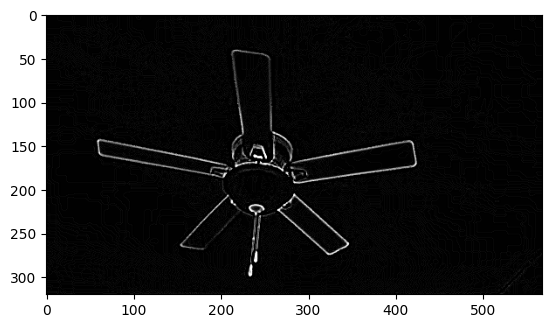

In [201]:
plt.imshow(np.repeat(tmp[:, :, None], 3, axis=-1))

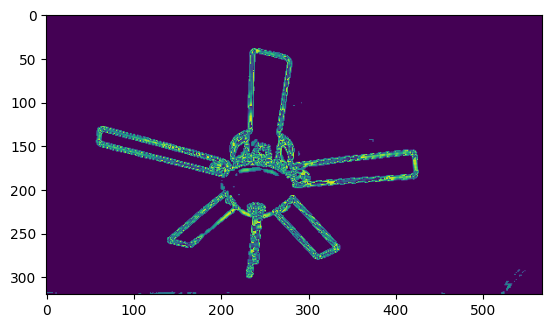

In [277]:
plt.imshow(filter_image(frame_2)*10)

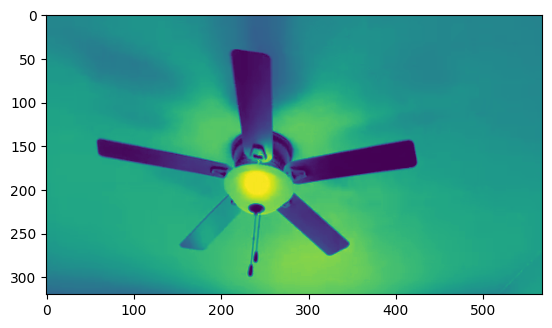

In [214]:
 # get frames
frame_1 = cv2.cvtColor(cv2.imread(frame_paths[i-2]), cv2.COLOR_BGR2GRAY)
frame_2 = cv2.cvtColor(cv2.imread(frame_paths[i-1]), cv2.COLOR_BGR2GRAY)
frame_3 = cv2.cvtColor(cv2.imread(frame_paths[i]), cv2.COLOR_BGR2GRAY)

plt.imshow(frame_3)

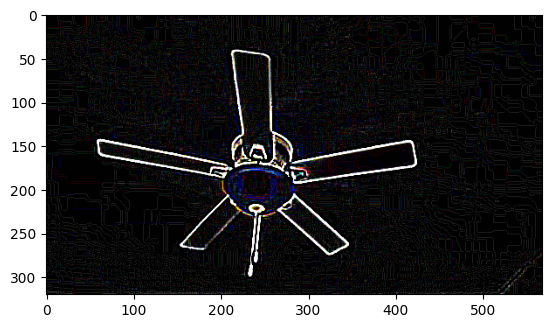

In [215]:
# Filter
frame_1 = filter_image(frame)
frame_2 = filter_image(frame)
frame_3 = filter_image(frame)

plt.imshow(frame_3)